In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

def cart_feature_selection(df, target_column, n_features=5):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    cart = RandomForestClassifier(random_state=42)
    #cart = XGBClassifier(random_state=42)
    cart.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': cart.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected_features = feature_importance['feature'][:n_features].tolist()
    
    return selected_features



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import creator, base, tools, algorithms

def genetic_feature_selection(df, target_column, n_generations=50, population_size=50):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        selected_features = X.columns[np.array(individual, dtype=bool)]
        if len(selected_features) == 0:
            return 0,
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(clf, X[selected_features], y, cv=5)
        return np.mean(scores),

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, verbose=False)

    best_individual = tools.selBest(population, k=1)[0]
    selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return selected_features

In [111]:
db_1 = pd.read_csv('New_DB_2.csv')
db_0 = pd.read_csv('New_DB_0.csv')
db_1 = db_1.drop(columns='Valor')
db_0 = db_0.drop(columns='Valor')
db_1['Fecha Evento'] = pd.to_datetime(db_1['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
db_0['Fecha Evento'] = pd.to_datetime(db_0['Fecha Evento'], format='%d/%m/%Y', errors='coerce')

In [112]:
raw = pd.read_csv('data_processed.csv')
raw = raw.drop_duplicates(subset=['Latitud', 'Longitud', 'Fecha Evento'])
raw = raw.reset_index()
raw['Fecha Evento'] = pd.to_datetime(raw['Fecha Evento'], format='%d/%m/%Y', errors='coerce')

In [113]:
df_1 = pd.read_csv('test_data_1')
df_0 = pd.read_csv('test_data_0_2')
df_1 = df_1.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df_0 = df_0.drop(columns=['Unnamed: 0'])
df_1['Valor'] = 1
df_0['Valor'] = 0
df_1['Fecha Evento'] = raw['Fecha Evento']
df_0['Fecha Evento'] = raw['Fecha Evento']
#df_1['Fecha Evento'] = pd.to_datetime(df_1['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
#df_0['Fecha Evento'] = pd.to_datetime(df_0['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
df_1.shape, df_0.shape


((602, 137), (602, 137))

In [114]:
fecha_evento_1 = df_1['Fecha Evento']
fecha_evento_0 = df_0['Fecha Evento']
df_1 = df_1.dropna()
df_0 = df_0.dropna()
df_1['Fecha Evento'] = fecha_evento_1
df_0['Fecha Evento'] = fecha_evento_0

In [115]:
df_0 = pd.merge(df_0 , db_0, on=['Latitud', 'Longitud', 'Fecha Evento'], how='inner')
df_1 = pd.merge(df_1 , db_1, on=['Latitud', 'Longitud', 'Fecha Evento'], how='inner')

In [110]:
df_1['Región']

0      Los Lagos
1      Los Lagos
2      Los Lagos
3      Los Lagos
4      Los Lagos
         ...    
360       Biobío
361       Biobío
362       Biobío
363       Biobío
364       Biobío
Name: Región, Length: 365, dtype: object

In [97]:
import seaborn as sns  
import matplotlib.pyplot as plt  

def graficar_frecuencia_variable_categorica(dataframe, columna):
    """
    Función para graficar la frecuencia de una columna con variable categórica.
    
    Parámetros:
    - dataframe: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna cuya frecuencia se desea graficar.
    """
    # Contar las ocurrencias de cada categoría en la columna
    conteo = dataframe[columna].value_counts()
    
    # Crear la gráfica de barras
    plt.figure(figsize=(6, 5))
    ax = conteo.plot(kind='bar', color='gray', edgecolor='black', width=0.9)
    
    # Mostrar el número encima de cada barra
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    # Personalización del gráfico
    plt.title(f'Frecuencia de Regiones')
    plt.xlabel(f'{columna}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    
    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()


graficar_frecuencia_variable_categorica(df, 'Región')

KeyError: 'Región'

In [98]:
df = df[df['Latitud'] < 0.19]

KeyError: 'Latitud'

In [99]:
df[['Latitud', 'Longitud']].describe()

KeyError: "None of [Index(['Latitud', 'Longitud'], dtype='object')] are in the [columns]"

In [116]:
df_1 = df_1.drop(columns=['valor_humedad_suelo2','valor_humedad_suelo3', 'valor_humedad_suelo4',
       'Tipo Remoción en masa', 'Unnamed: 0','Región', 'Comuna', 'Factor desencadenante',
       'Sistema Georeferencia', 'Cota (m.s.n.m)', 'Fecha Evento'])
df_0 = df_0.drop(columns=['valor_humedad_suelo2','valor_humedad_suelo3', 'valor_humedad_suelo4',
       'Tipo Remoción en masa', 'Unnamed: 0','Región', 'Comuna', 'Factor desencadenante',
       'Sistema Georeferencia', 'Cota (m.s.n.m)', 'Fecha Evento'])
#df_1 = df_1.fillna(df_1.mean())
#df_0 = df_0.fillna(df_0.mean())

In [14]:
import pandas as pd
import numpy as np

def eliminar_caracteristicas(df, umbral):
    """
    Elimina características de un DataFrame basado en la correlación.
    
    Args:
    - df (pd.DataFrame): DataFrame con las características.
    - umbral (float): Umbral de correlación para eliminar características.
    
    Returns:
    - pd.DataFrame: DataFrame con las características restantes.
    - int: Número de características eliminadas.
    """
    # Calcular la matriz de correlación
    correlaciones = df.corr().abs()
    
    # Crear una máscara para evitar considerar la diagonal principal
    mask = np.triu(np.ones_like(correlaciones, dtype=bool), k=1)
    
    # Identificar pares de características con alta correlación
    to_drop = set()
    for i in range(len(correlaciones.columns)):
        for j in range(i):
            if correlaciones.iloc[i, j] > umbral:
                colname = correlaciones.columns[i]
                to_drop.add(colname)
    
    # Eliminar las características
    df_reducido = df.drop(columns=to_drop)
    
    # Número de características eliminadas
    num_eliminadas = len(to_drop)
    
    return df_reducido, num_eliminadas

def prueba_umbral(df, umbrales):
    """
    Prueba diferentes umbrales y guarda el número de características eliminadas.
    
    Args:
    - df (pd.DataFrame): DataFrame con las características.
    - umbrales (list): Lista de umbrales para probar.
    
    Returns:
    - pd.DataFrame: DataFrame con los resultados de la prueba.
    """
    resultados = []
    
    for umbral in umbrales:
        df_reducido, num_eliminadas = eliminar_caracteristicas(df, umbral)
        resultados.append({'Umbral': umbral, 'Caracteristicas eliminadas': num_eliminadas})
    
    return pd.DataFrame(resultados)

# Ejemplo de uso:
# df = pd.DataFrame(...)  # Reemplaza con tu DataFrame real
umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
resultados = prueba_umbral(df_1, umbrales)

print(resultados)


   Umbral  Caracteristicas eliminadas
0     0.1                         137
1     0.2                         137
2     0.3                         133
3     0.4                         133
4     0.5                         128
5     0.6                         126
6     0.7                         122
7     0.8                         114
8     0.9                          95


In [43]:
df_reducido, num_eliminadas = eliminar_caracteristicas(df_1, 0.99)
num_eliminadas

40

In [117]:
df = pd.concat([df_0,df_1])

#df = df[df_reducido.columns]
df_x = df.drop(columns='Valor')
df = df.drop(columns=['Longitud', 'Latitud'])
df_y = df.Valor
df_x.shape, df_y.shape

((734, 138), (734,))

,PIRange_Bulkd.0-5cm.tif,PIRange_Bulkd.100-200cm.tif,PIRange_Bulkd.15-30cm.tif,PIRange_Bulkd.30-60cm.tif,PIRange_Bulkd.5-15cm.tif,PIRange_Bulkd.60-100cm.tif,PIRange_Clay.0-5cm.tif,PIRange_Clay.100-200cm.tif,PIRange_Clay.15-30cm.tif,PIRange_Clay.30-60cm.tif,...,Tex_Class.0-5cm.tif,Tex_Class.100-200cm.tif,Tex_Class.15-30cm.tif,Tex_Class.30-60cm.tif,Tex_Class.5-15cm.tif,Tex_Class.60-100cm.tif,Valor,PP,valor_humedad_suelo1,slope
0,0.609,0.689,0.483,0.641,0.550,0.650,22.358000,32.235001,22.490000,26.009001,...,8.0,8.0,8.0,8.0,4.0,8.0,0,13.532034,0.421875,32.357300
1,0.609,0.689,0.483,0.641,0.550,0.650,22.358000,32.235001,22.490000,26.009001,...,8.0,8.0,8.0,8.0,4.0,8.0,0,238.139918,0.438995,32.357300
2,0.595,0.753,0.484,0.621,0.497,0.706,23.513000,32.325001,25.268002,31.559998,...,8.0,8.0,7.0,7.0,7.0,7.0,0,32.059045,0.520004,37.497812
3,0.589,0.682,0.482,0.614,0.498,0.656,25.056000,45.129002,25.813000,32.742996,...,10.0,1.0,9.0,1.0,1.0,1.0,0,0.000000,0.478973,36.717389
4,0.659,0.689,0.573,0.675,0.553,0.660,21.844999,30.417000,18.743000,21.934999,...,8.0,4.0,8.0,8.0,8.0,4.0,0,2.191190,0.438095,60.517945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.615,0.711,0.513,0.633,0.501,0.679,30.555002,48.961998,26.193001,32.199997,...,2.0,2.0,2.0,2.0,1.0,2.0,1,28.563241,0.408554,29.928362
361,0.596,0.716,0.488,0.620,0.499,0.691,24.928001,43.293999,24.924999,31.129002,...,2.0,2.0,7.0,2.0,2.0,2.0,1,12.244763,0.516968,48.232759
362,0.589,0.708,0.484,0.614,0.492,0.687,25.048000,43.327999,24.853001,31.122000,...,2.0,2.0,2.0,2.0,2.0,2.0,1,3.830269,0.471466,48.232759
363,0.596,0.716,0.488,0.620,0.499,0.691,24.928001,43.293999,24.924999,31.129002,...,2.0,2.0,7.0,2.0,2.0,2.0,1,328.705409,0.519699,48.232759


In [57]:
df = df.dropna()
df.shape

(658, 97)

In [60]:
# Usar CART para seleccionar características
cart_features = cart_feature_selection(df, 'Valor', n_features=45)
print("Características seleccionadas por CART:", cart_features)

# Usar algoritmo genético para seleccionar características
#genetic_features = genetic_feature_selection(df, 'Valor')
#print("Características seleccionadas por el algoritmo genético:", genetic_features)

Características seleccionadas por CART: ['PIRange_Clay.0-5cm.tif', 'PIRange_Bulkd.5-15cm.tif', 'PIRange_Sand.30-60cm.tif', 'PIRange_Sand.5-15cm.tif', 'PIRange_Sand.100-200cm.tif', 'PIRange_Sand.60-100cm.tif', 'PIRange_Sand.0-5cm.tif', 'slope', 'PIRange_Bulkd.30-60cm.tif', 'PIRange_Sand.15-30cm.tif', 'PIRange_Clay.15-30cm.tif', 'n_0-5cm.tif', 'ksat_30-60cm.tif', 'PIRange_Clay.5-15cm.tif', 'ksat_15-30cm.tif', 'PIRange_Clay.30-60cm.tif', 'n_30-60cm.tif', 'ksat_100-200cm.tif', 'ksat_60-100cm.tif', 'PWP.30-60cm.tif', 'PIRange_Bulkd.60-100cm.tif', 'Clay.0-5cm.tif', 'PIRange_Clay.100-200cm.tif', 'PWP.15-30cm.tif', 'n_100-200cm.tif', 'PIRange_Clay.60-100cm.tif', 'PWP.100-200cm.tif', 'Bulkd.5-15cm.tif', 'theta_s_100-200cm.tif', 'theta_s_5-15cm.tif', 'PIRange_Bulkd.0-5cm.tif', 'theta_r_100-200cm.tif', 'Clay.15-30cm.tif', 'FC.100-200cm.tif', 'theta_r_15-30cm.tif', 'theta_s_15-30cm.tif', 'alpha.100-200cm.tif', 'AvMoist.15-30cm.tif', 'AvMoist.60-100cm.tif', 'PP', 'PWP.5-15cm.tif', 'Sand.100-200cm.t

In [61]:
cart_features

['PIRange_Clay.0-5cm.tif',
 'PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.30-60cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'PIRange_Sand.60-100cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'slope',
 'PIRange_Bulkd.30-60cm.tif',
 'PIRange_Sand.15-30cm.tif',
 'PIRange_Clay.15-30cm.tif',
 'n_0-5cm.tif',
 'ksat_30-60cm.tif',
 'PIRange_Clay.5-15cm.tif',
 'ksat_15-30cm.tif',
 'PIRange_Clay.30-60cm.tif',
 'n_30-60cm.tif',
 'ksat_100-200cm.tif',
 'ksat_60-100cm.tif',
 'PWP.30-60cm.tif',
 'PIRange_Bulkd.60-100cm.tif',
 'Clay.0-5cm.tif',
 'PIRange_Clay.100-200cm.tif',
 'PWP.15-30cm.tif',
 'n_100-200cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PWP.100-200cm.tif',
 'Bulkd.5-15cm.tif',
 'theta_s_100-200cm.tif',
 'theta_s_5-15cm.tif',
 'PIRange_Bulkd.0-5cm.tif',
 'theta_r_100-200cm.tif',
 'Clay.15-30cm.tif',
 'FC.100-200cm.tif',
 'theta_r_15-30cm.tif',
 'theta_s_15-30cm.tif',
 'alpha.100-200cm.tif',
 'AvMoist.15-30cm.tif',
 'AvMoist.60-100cm.tif',
 'PP',
 'PWP.5-15cm.tif',
 'Sand.100-200cm.

In [66]:
cart_features = cart_feature_selection(df, 'Valor', n_features=60)
print("Características seleccionadas por CART:", cart_features)
cart_features

Características seleccionadas por CART: ['PIRange_Clay.0-5cm.tif', 'PIRange_Bulkd.5-15cm.tif', 'PIRange_Sand.30-60cm.tif', 'PIRange_Sand.5-15cm.tif', 'PIRange_Sand.100-200cm.tif', 'PIRange_Sand.60-100cm.tif', 'PIRange_Sand.0-5cm.tif', 'slope', 'PIRange_Bulkd.30-60cm.tif', 'PIRange_Sand.15-30cm.tif', 'PIRange_Clay.15-30cm.tif', 'n_0-5cm.tif', 'ksat_30-60cm.tif', 'PIRange_Clay.5-15cm.tif', 'ksat_15-30cm.tif', 'PIRange_Clay.30-60cm.tif', 'n_30-60cm.tif', 'ksat_100-200cm.tif', 'ksat_60-100cm.tif', 'PWP.30-60cm.tif', 'PIRange_Bulkd.60-100cm.tif', 'Clay.0-5cm.tif', 'PIRange_Clay.100-200cm.tif', 'PWP.15-30cm.tif', 'n_100-200cm.tif', 'PIRange_Clay.60-100cm.tif', 'PWP.100-200cm.tif', 'Bulkd.5-15cm.tif', 'theta_s_100-200cm.tif', 'theta_s_5-15cm.tif', 'PIRange_Bulkd.0-5cm.tif', 'theta_r_100-200cm.tif', 'Clay.15-30cm.tif', 'FC.100-200cm.tif', 'theta_r_15-30cm.tif', 'theta_s_15-30cm.tif', 'alpha.100-200cm.tif', 'AvMoist.15-30cm.tif', 'AvMoist.60-100cm.tif', 'PP', 'PWP.5-15cm.tif', 'Sand.100-200cm.t

['PIRange_Clay.0-5cm.tif',
 'PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.30-60cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'PIRange_Sand.60-100cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'slope',
 'PIRange_Bulkd.30-60cm.tif',
 'PIRange_Sand.15-30cm.tif',
 'PIRange_Clay.15-30cm.tif',
 'n_0-5cm.tif',
 'ksat_30-60cm.tif',
 'PIRange_Clay.5-15cm.tif',
 'ksat_15-30cm.tif',
 'PIRange_Clay.30-60cm.tif',
 'n_30-60cm.tif',
 'ksat_100-200cm.tif',
 'ksat_60-100cm.tif',
 'PWP.30-60cm.tif',
 'PIRange_Bulkd.60-100cm.tif',
 'Clay.0-5cm.tif',
 'PIRange_Clay.100-200cm.tif',
 'PWP.15-30cm.tif',
 'n_100-200cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PWP.100-200cm.tif',
 'Bulkd.5-15cm.tif',
 'theta_s_100-200cm.tif',
 'theta_s_5-15cm.tif',
 'PIRange_Bulkd.0-5cm.tif',
 'theta_r_100-200cm.tif',
 'Clay.15-30cm.tif',
 'FC.100-200cm.tif',
 'theta_r_15-30cm.tif',
 'theta_s_15-30cm.tif',
 'alpha.100-200cm.tif',
 'AvMoist.15-30cm.tif',
 'AvMoist.60-100cm.tif',
 'PP',
 'PWP.5-15cm.tif',
 'Sand.100-200cm.

In [67]:
new_cart_features = cart_features
#new_cart_features.append('PP')
#new_cart_features.append('slope')
#new_cart_features.append('valor_humedad_suelo1')

In [134]:
cart_features

['PIRange_Clay.0-5cm.tif',
 'PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.30-60cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'PIRange_Sand.60-100cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'slope',
 'PIRange_Bulkd.30-60cm.tif',
 'PIRange_Sand.15-30cm.tif',
 'PIRange_Clay.15-30cm.tif',
 'n_0-5cm.tif',
 'ksat_30-60cm.tif',
 'PIRange_Clay.5-15cm.tif',
 'ksat_15-30cm.tif',
 'PIRange_Clay.30-60cm.tif',
 'n_30-60cm.tif',
 'ksat_100-200cm.tif',
 'ksat_60-100cm.tif',
 'PWP.30-60cm.tif',
 'PIRange_Bulkd.60-100cm.tif',
 'Clay.0-5cm.tif',
 'PIRange_Clay.100-200cm.tif',
 'PWP.15-30cm.tif',
 'n_100-200cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PWP.100-200cm.tif',
 'Bulkd.5-15cm.tif',
 'theta_s_100-200cm.tif',
 'theta_s_5-15cm.tif',
 'PIRange_Bulkd.0-5cm.tif',
 'theta_r_100-200cm.tif',
 'Clay.15-30cm.tif',
 'FC.100-200cm.tif',
 'theta_r_15-30cm.tif',
 'theta_s_15-30cm.tif',
 'alpha.100-200cm.tif',
 'AvMoist.15-30cm.tif',
 'AvMoist.60-100cm.tif',
 'PP',
 'PWP.5-15cm.tif',
 'Sand.100-200cm.

In [135]:
X = df[cart_features]
y = df.Valor

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (587, 60), Numero de test: (147, 60)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 95.23809523809523


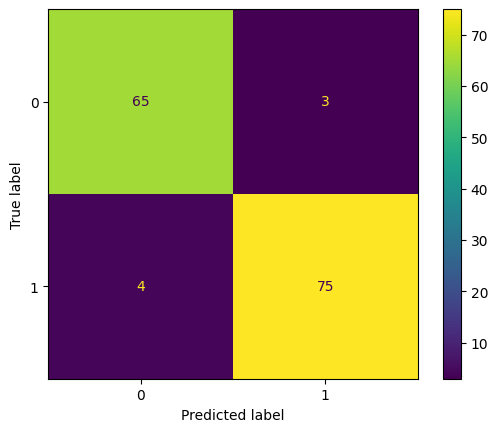

In [139]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from deap import creator, base, tools, algorithms

def enhanced_genetic_feature_selection(df, target_column, n_generations=100, population_size=50):
    # Paso 1: Eliminar variables correlacionadas
    def remove_correlated_features(X, threshold=0.95):
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return X.drop(to_drop, axis=1)

    # Paso 2: Aplicar CART para eliminar variables menos significativas
    def select_features_with_cart(X, y, max_features=50):
        clf = DecisionTreeClassifier(random_state=42)
        selector = SelectFromModel(clf, max_features=max_features)
        selector = selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()

    # Preprocesamiento
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X = remove_correlated_features(X)
    selected_features = select_features_with_cart(X, y)
    X = X[selected_features]

    # Configuración del algoritmo genético
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        selected_features = X.columns[np.array(individual, dtype=bool)]
        if len(selected_features) == 0:
            return float('inf'),
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)
        penalty = len(selected_features) / len(X.columns)
        return mse + penalty,

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    hof = tools.HallOfFame(1)
    
    final_pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.9, mutpb=0.1, 
                                             ngen=n_generations, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    final_selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return final_selected_features, logbook



In [100]:
selected_features, logbook = enhanced_genetic_feature_selection(df, 'Valor')
print("Características seleccionadas:", selected_features)
print("Evolución del fitness:", logbook)

c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


KeyboardInterrupt: 

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import creator, base, tools, algorithms

def evaluar_cromosoma(individual, X, y, n_caracteristicas):
    # Decodificar el cromosoma
    selected_features = X.columns[np.array(individual, dtype=bool)]
    
    # Verificar restricciones
    if len(selected_features) == 0:
        return 1,  # Penalización máxima si no se selecciona ninguna característica
    
    # Entrenar el modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')
    
    # Obtener medida de rendimiento (1 - sensibilidad para minimización)
    rendimiento = 1 - np.mean(scores)
    
    # Castigar al cromosoma basado en la cantidad de características
    penalizacion = len(selected_features) / n_caracteristicas
    
    # Devolver el valor de evaluación
    return rendimiento + penalizacion,

def seleccion_caracteristicas_genetico(df, target_column, n_generations=50, population_size=50):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    n_caracteristicas = len(X.columns)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_caracteristicas)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluar_cromosoma, X=X, y=y, n_caracteristicas=n_caracteristicas)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    for gen in range(n_generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.9, mutpb=0.05 + (gen / n_generations) * 0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)
        record = stats.compile(population)
        logbook.record(gen=gen, **record)
        print(f"Generación {gen}: {record}")

    best_individual = hof[0]
    selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return selected_features, logbook, hof



In [74]:
target_column = 'Valor'
mejores_caracteristicas, logbook, hof = seleccion_caracteristicas_genetico(df, target_column)
print("Mejores características seleccionadas:", mejores_caracteristicas)
print("Mejor fitness:", hof[0].fitness.values[0])

c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generación 0: {'avg': 0.7356097617395327, 'min': 0.6554823039555866}
Generación 1: {'avg': 0.6980962294702752, 'min': 0.6522669442516771}
Generación 2: {'avg': 0.672450815405968, 'min': 0.6362147235715938}
Generación 3: {'avg': 0.6509450034698127, 'min': 0.6306673606291928}
Generación 4: {'avg': 0.6361403539208883, 'min': 0.6107159380060144}
Generación 5: {'avg': 0.6277718309044644, 'min': 0.5696984154522322}
Generación 6: {'avg': 0.6133254973398102, 'min': 0.5526919962988665}
Generación 7: {'avg': 0.5932341834374277, 'min': 0.5690839694656487}
Generación 8: {'avg': 0.5756036606523247, 'min': 0.5571290191996299}
Generación 9: {'avg': 0.5675918922044876, 'min': 0.544083969465649}
Generación 10: {'avg': 0.5588643303261623, 'min': 0.5424025560953041}
Generación 11: {'avg': 0.5489500346981263, 'min': 0.4900488665278741}
Generación 12: {'avg': 0.5439048693037243, 'min': 0.5216082581540595}
Generación 13: {'avg': 0.537404030765672, 'min': 0.526424068933611}
Generación 14: {'avg': 0.531059912

In [75]:
mejores_caracteristicas

['PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'alpha_0-5cm.tif',
 'alpha_60-100cm.tif',
 'AvMoist.5-15cm.tif',
 'FC.60-100cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_5-15cm.tif',
 'PWP.0-5cm.tif',
 'ksat.5-15cm.tif',
 'Sand.0-5cm.tif',
 'slope']

In [76]:
mejores_caracteristicas.extend(['PP', 'valor_humedad_suelo1'])
mejores_caracteristicas

['PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'alpha_0-5cm.tif',
 'alpha_60-100cm.tif',
 'AvMoist.5-15cm.tif',
 'FC.60-100cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_5-15cm.tif',
 'PWP.0-5cm.tif',
 'ksat.5-15cm.tif',
 'Sand.0-5cm.tif',
 'slope',
 'PP',
 'valor_humedad_suelo1']

In [119]:
X = df[mejores_caracteristicas]
y = df.Valor

In [78]:
mejores_caracteristicas.extend(['PP', 'slope', 'valor_humedad_suelo1'])

In [118]:
mejores_caracteristicas = ['PIRange_Bulkd.30-60cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'AWC_30-60cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_30-60cm.tif',
 'PWP.5-15cm.tif',
 'theta_r_0-5cm.tif',
 'theta_r_30-60cm.tif',
 'theta_r_5-15cm.tif',
 'alpha.30-60cm.tif',
 'ksat.100-200cm.tif',
 'n.30-60cm.tif',
 'n.5-15cm.tif',
 'Bulkd.60-100cm.tif',
 'Clay.100-200cm.tif',
 'Clay.15-30cm.tif',
 'Clay.60-100cm.tif',
 'Sand.30-60cm.tif',
 'Tex_Class.0-5cm.tif',
 'PP',
 'slope',
 'valor_humedad_suelo1']

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (587, 25), Numero de test: (147, 25)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 88.43537414965986


In [143]:
data = df[mejores_caracteristicas]
data['Valor'] = df.Valor

C:\Users\ivo\AppData\Local\Temp\ipykernel_10316\337141860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Valor'] = df.Valor


In [144]:
data_aux_1 = data[data.Valor == 1]
data_aux_0 = data[data.Valor == 0]
data_aux_0 = data_aux_0.drop(columns='Valor')
data_aux_1 = data_aux_1.drop(columns='Valor')

In [145]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class PUBagging:
    def __init__(self, num_iterations=10, sample_ratio=1.0, random_state=42):
        self.num_iterations = num_iterations
        self.sample_ratio = sample_ratio
        self.random_state = random_state
        self.classifiers = []
        self.probabilities = None

    def fit(self, landslide_samples, unlabeled_samples):
        np.random.seed(self.random_state)

        if isinstance(landslide_samples, np.ndarray):
            landslide_samples_array = landslide_samples
        else:
            landslide_samples_array = landslide_samples.values  # Convert to numpy array if it's a DataFrame

        if isinstance(unlabeled_samples, np.ndarray):
            unlabeled_samples_array = unlabeled_samples
        else:
            unlabeled_samples_array = unlabeled_samples.values  # Convert to numpy array if it's a DataFrame

        num_samples = len(landslide_samples_array)
        num_unlabeled = len(unlabeled_samples_array)

        for _ in range(self.num_iterations):
            # Step 1: Sample equal number of unlabeled samples as non-landslide samples
            non_landslide_indices = np.random.choice(num_unlabeled, size=int(num_samples * self.sample_ratio), replace=False)
            non_landslide_samples = unlabeled_samples_array[non_landslide_indices]

            # Combine with landslide samples to form training set
            X_train = np.vstack((landslide_samples_array, non_landslide_samples))
            y_train = np.hstack((np.ones(num_samples), np.zeros(len(non_landslide_samples))))

            # Step 2: Train decision tree classifier
            clf = DecisionTreeClassifier(random_state=self.random_state)
            clf.fit(X_train, y_train)
            self.classifiers.append(clf)

            # Step 3: Predict probability of being landslide for unlabeled samples
            prob_landslide = clf.predict_proba(unlabeled_samples_array)[:, 1]

            if self.probabilities is None:
                self.probabilities = prob_landslide
            else:
                self.probabilities += prob_landslide

        # Step 4: Average probabilities over iterations
        self.probabilities /= self.num_iterations

    def predict_proba(self, unlabeled_samples):
        if isinstance(unlabeled_samples, np.ndarray):
            return self.probabilities
        else:
            return self.probabilities[:len(unlabeled_samples)]  # Return probabilities for original DataFrame

# Example usage:
if __name__ == '__main__':
    import pandas as pd
    
    # Example data (replace with your own data)
    landslide_samples = data_aux_1# Example landslide samples as DataFrame
    unlabeled_samples = data_aux_0# Example unlabeled samples as DataFrame

    # Create PU Bagging instance
    pu_bagging = PUBagging(num_iterations=5, sample_ratio=0.4, random_state=42)

    # Fit the model
    pu_bagging.fit(landslide_samples, unlabeled_samples)

    # Predict probabilities for unlabeled samples
    probabilities = pu_bagging.predict_proba(unlabeled_samples)
    print("Predicted probabilities:", probabilities)

Predicted probabilities: [0.45730524 0.45730524 0.61382697 0.65730524 0.45730524 0.45730524
 0.45730524 0.45730524 0.45730524 0.22318841 0.61382697 0.61382697
 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524
 0.61382697 0.64034664 0.45730524 0.65730524 0.45730524 0.45730524
 0.45730524 0.42477571 0.42477571 0.60414079 0.45730524 0.48075397
 0.61382697 0.61382697 0.45730524 0.65730524 0.61382697 0.82477571
 0.62477571 0.61382697 0.82477571 0.42477571 0.62477571 0.62477571
 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524
 0.65217703 0.45730524 0.61382697 0.61382697 0.45730524 0.45730524
 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524
 0.45730524 0.45730524 0.45730524 0.45730524 0.45730524 0.46980524
 0.46980524 0.46980524 0.45730524 0.45730524 0.45730524 0.45730524
 0.45730524 0.45730524 0.45730524 0.65217703 0.45730524 0.45730524
 0.61382697 0.61382697 0.61382697 0.45730524 0.45730524 0.45730524
 0.15       0.61382697 0.62477571 0.6

In [146]:
# Suponiendo que ya tienes las probabilidades predichas por pu_bagging.predict_proba(unlabeled_samples)

# Umbral para seleccionar muestras no deslizamiento
threshold = 0.5  # Puedes ajustar este umbral según tus necesidades

# Filtrar muestras no deslizamiento por debajo del umbral
non_landslide_indices = np.where(probabilities < threshold)[0]
selected_non_landslide_samples = unlabeled_samples.iloc[non_landslide_indices]

# Ejemplo de cómo podrías utilizar las muestras seleccionadas
print("Muestras no deslizamiento seleccionadas:")
print(selected_non_landslide_samples)

Muestras no deslizamiento seleccionadas:
     PIRange_Clay.0-5cm.tif  PIRange_Bulkd.5-15cm.tif  \
0                 22.358000                     0.550   
1                 22.358000                     0.550   
4                 21.844999                     0.553   
5                 24.192999                     0.528   
6                 22.917000                     0.503   
..                      ...                       ...   
360               25.174999                     0.496   
361               24.321003                     0.492   
362               25.174999                     0.496   
363               24.475998                     0.501   
366               24.475998                     0.501   

     PIRange_Sand.30-60cm.tif  PIRange_Sand.5-15cm.tif  \
0                   32.817001                31.408005   
1                   32.817001                31.408005   
4                   32.962997                31.689995   
5                   33.968002             

In [147]:
selected_non_landslide_samples['Valor'] = 0
data_aux_1['Valor'] = 1

data = pd.concat([data_aux_1, selected_non_landslide_samples])
data_y = data['Valor']
data = data.drop(columns=['Valor'])

C:\Users\ivo\AppData\Local\Temp\ipykernel_10316\38701351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_non_landslide_samples['Valor'] = 0


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (474, 60), Numero de test: (119, 60)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


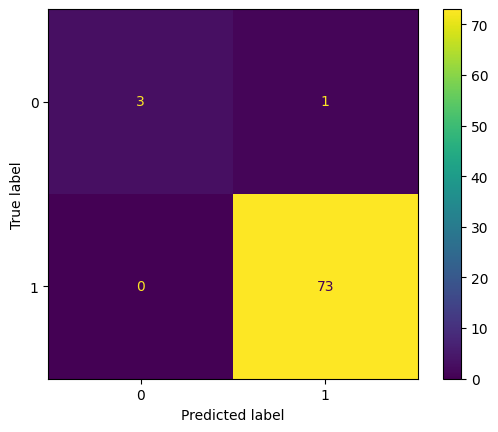

In [132]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        72
           1       0.88      0.89      0.89        75

    accuracy                           0.88       147
   macro avg       0.88      0.88      0.88       147
weighted avg       0.88      0.88      0.88       147



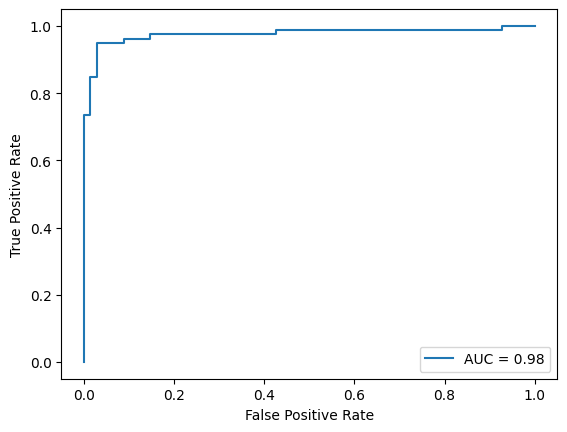

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
predictions = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()

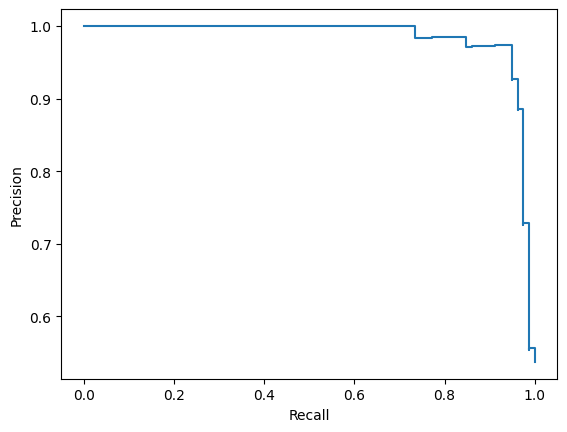

In [141]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [61]:
mejores_caracteristicas

['PIRange_Bulkd.30-60cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'AWC_30-60cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_30-60cm.tif',
 'PWP.5-15cm.tif',
 'theta_r_0-5cm.tif',
 'theta_r_30-60cm.tif',
 'theta_r_5-15cm.tif',
 'alpha.30-60cm.tif',
 'ksat.100-200cm.tif',
 'n.30-60cm.tif',
 'n.5-15cm.tif',
 'Bulkd.60-100cm.tif',
 'Clay.100-200cm.tif',
 'Clay.15-30cm.tif',
 'Clay.60-100cm.tif',
 'Sand.30-60cm.tif',
 'Tex_Class.0-5cm.tif',
 'PP',
 'slope',
 'valor_humedad_suelo1']